In [ ]:
import numpy as np
import pandas as pd

import math
import time

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/capstoneproject/acceptability_corpus/cola_public/raw/'

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv(path+'in_domain_train.tsv',sep="\t", header=None)
print(train_df.shape)
print(train_df.iloc[:,1].mean())
train_df.sample(5)

(8551, 4)
0.704362062916618


,0,1,2,3
1640,r-67,1,NaN,Here's a knife for you to cut up the onions with.
8094,ad03,1,NaN,Hierarchy of Projections:
127,cj99,0,*,"When it rains harder, how much faster a flow t..."
7255,sks13,1,NaN,For the girl to put a picture there would surp...
3284,l-93,0,*,These abandoned buildings lodged with squatters.


In [ ]:
val_df = pd.read_csv(path+'in_domain_dev.tsv',sep="\t", header=None)
print(val_df.shape)
print(val_df.iloc[:,1].mean())
val_df.sample(5)

(527, 4)
0.6925996204933587


,0,1,2,3
46,bc01,1,NaN,It is nice to go abroad.
225,ks08,0,*,Some my jobs are in jeopardy.
364,c_13,1,NaN,He danced.
64,bc01,1,NaN,John often meets Mary.
215,l-93,1,NaN,Penny skated around the rink.


In [ ]:
test_df = pd.read_csv(path+'cola_in_domain_test.tsv',sep="\t", index_col='Id')
print(test_df.shape)
test_df.sample(5)

(530, 1)


,Sentence
Id,
245,John has been at Stanford for four years.
387,George thinks that Julia cooked some beef waff...
368,Everyone should be able to defend themselves.
190,Brenda met with Molly.
349,I've thought about enough for twelve to think ...


In [ ]:
test1_df = pd.read_csv(path+'out_of_domain_dev.tsv',sep="\t", header=None)
print(test1_df.shape)
print(test1_df.iloc[:,1].mean())
test1_df.sample(5)

(516, 4)
0.686046511627907


,0,1,2,3
112,c-05,1,NaN,Books were taken from each student and given t...
513,w_80,0,*,John bought a dog for himself to play with.
399,swb04,0,*,The cat were bitten by the dog.
291,swb04,0,*,Terry delighted.
349,swb04,1,NaN,Susan devoted herself to linguistics.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
# Concatenate train, validation, and test dataframes for consistency in preprocessing
combined_df = pd.concat([train_df, val_df, test_df]) #with test set
combined_df1 = pd.concat([train_df, val_df, test1_df]) #out of domain dev as test

# Assuming the text data is in a column named 'text'
X_train = train_df[3]
X_val = val_df[3]
X_test = test_df['Sentence']
X_test1 = test1_df[3]

# Labels
y_train = train_df[1]
y_val = val_df[1]
y_test = test1_df[1]

TF-IDF Vectorization

In [ ]:
# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)
X_test1_tfidf = vectorizer.transform(X_test1)

In [ ]:
# Initialize SVM classifier
svm_classifier = SVC(kernel='linear')

# Train the SVM classifier
svm_classifier.fit(X_train_tfidf, y_train)

SVC(kernel='linear')

In [ ]:
# Predictions on validation set
val_predictions = svm_classifier.predict(X_val_tfidf)

In [ ]:
# Calculate accuracy on validation set
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.6850094876660342


In [ ]:
# Predictions on test set
test_predictions = svm_classifier.predict(X_test_tfidf)
test1_predictions = svm_classifier.predict(X_test1_tfidf)

In [ ]:
# Calculate accuracy on out of domain dev set
test1_accuracy = accuracy_score(y_test, test1_predictions)
print("Test1 Accuracy:", test1_accuracy)

Test1 Accuracy: 0.6802325581395349


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

Confusion Matrix:
 [[  2 160]
 [  5 349]]


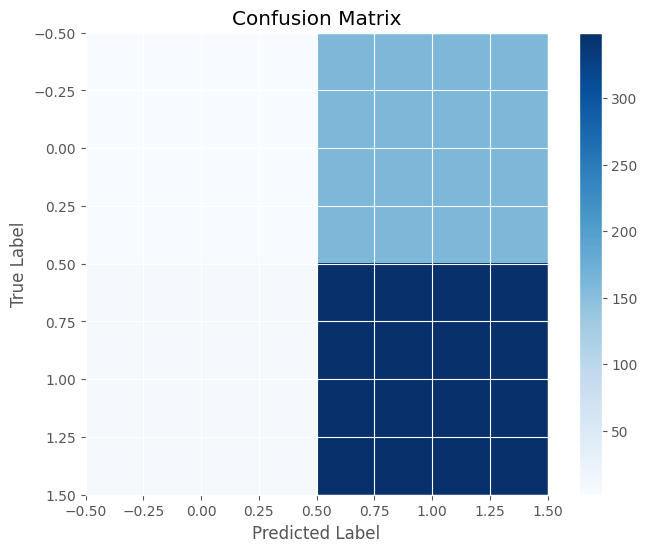

In [ ]:
conf_matrix = confusion_matrix(y_test, test1_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# 3. Precision, Recall, and F1-score
print("Classification Report:")
print(classification_report(y_test, test1_predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.01      0.02       162
           1       0.69      0.99      0.81       354

    accuracy                           0.68       516
   macro avg       0.49      0.50      0.42       516
weighted avg       0.56      0.68      0.56       516



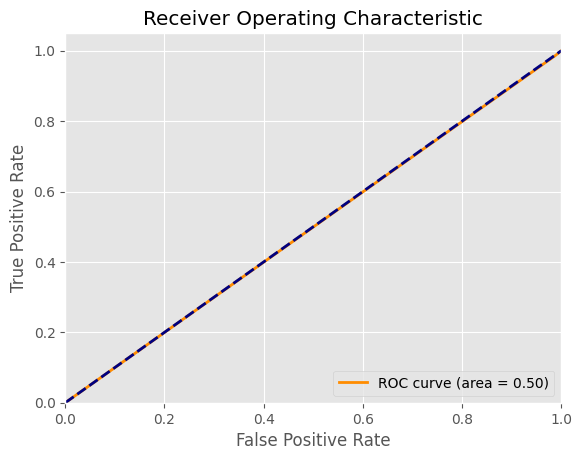

In [ ]:
# 4. ROC Curve and AUC (if binary classification)
if len(np.unique(y_test)) == 2:
    fpr, tpr, _ = roc_curve(y_test, test1_predictions)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# 5. Error Analysis
# individual instances where the model made incorrect predictions
incorrect_predictions = [(true_label, pred_label, text) for true_label, pred_label, text in zip(y_test, test1_predictions, X_test1) if true_label != pred_label]
print("Incorrect Predictions:")
for true_label, pred_label, text in incorrect_predictions:
    print("True Label:", true_label)
    print("Predicted Label:", pred_label)
    print("Text:", text)
    print()

Incorrect Predictions:
True Label: 0
Predicted Label: 1
Text: John ate dinner but I don't know who.

True Label: 0
Predicted Label: 1
Text: She mailed John a letter, but I don't know to whom.

True Label: 0
Predicted Label: 1
Text: She was bathing, but I couldn't make out who.

True Label: 0
Predicted Label: 1
Text: She knew French for Tom.

True Label: 0
Predicted Label: 1
Text: John is tall on several occasions.

True Label: 0
Predicted Label: 1
Text: The ship sank, but I don't know with what.

True Label: 0
Predicted Label: 1
Text: They noticed the painting, but I don't know for how long.

True Label: 0
Predicted Label: 1
Text: John was tall, but I don't know on what occasions.

True Label: 0
Predicted Label: 1
Text: I know that Meg's attracted to Harry, but they don't know who.

True Label: 0
Predicted Label: 1
Text: Since Jill said Joe had invited Sue, we didn't have to ask who.

True Label: 0
Predicted Label: 1
Text: She said she had spoken to everybody, but he wasn't sure who.



Word Embeddings

In [ ]:
glove_model_file = "/content/drive/My Drive/capstoneproject/Real-Fake without GloVe/real_fake_without_glove.pth"
vocab_file = "/content/drive/My Drive/capstoneproject/acceptability_corpus/vocab_100k.tsv"
embedding_file = "/content/drive/My Drive/capstoneproject/Real-Fake without GloVe/real_fake_without_glove.emb"
test_file = path+'cola_in_domain_test.tsv'
test1_file = path+'out_of_domain_dev.tsv'
testpy_file = "/content/drive/My Drive/capstoneproject/acceptability/test.py"

In [ ]:
# Construct the command with quoted file paths
command = f"python '{testpy_file}' -mf '{glove_model_file}' -vf '{vocab_file}' -ef '{embedding_file}' -d '{test_file}' -g"

# Execute the command
!{command}

Traceback (most recent call last):
  File "/content/drive/My Drive/capstoneproject/acceptability/test.py", line 3, in <module>
    from acceptability.modules.dataset import AcceptabilityDataset, Vocab, GloVeIntersectedVocab
ModuleNotFoundError: No module named 'acceptability'


In [ ]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors

# Load pre-trained GloVe embeddings
word_vectors = KeyedVectors.load_word2vec_format('path_to_glove_embeddings_file.txt', binary=False)

# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(test1_df[3])  # text_data is a list of sentences

FileNotFoundError: [Errno 2] No such file or directory: 'path_to_glove_embeddings_file.txt'

In [ ]:
# Convert text data to sequences of word indices
sequences = tokenizer.texts_to_sequences(text_data)

# Pad sequences to ensure uniform length
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Create an embedding matrix for words in the tokenizer vocabulary
embedding_dim = word_vectors.vector_size
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if word in word_vectors:
        embedding_matrix[index] = word_vectors[word]

# Convert text sequences to word embeddings
word_embeddings = np.array([embedding_matrix[word_index] for word_index in padded_sequences])

# Now word_embeddings contains the word embeddings for each sentence in text_data


In [ ]:
!pip install allennlp==0.9.0

In [ ]:
!pip install allennlp

In [ ]:
# from allennlp import commnds
# from allennlp.commands import elmo
from allennlp.commands.elmo import ElmoEmbedder

# Load pre-trained ELMo model
elmo = ElmoEmbedder()

In [ ]:
# Example sentences
sentences = test1_df[3]

# Obtain ELMo embeddings for each sentence
elmo_embeddings = elmo.embed_sentences(sentences)

In [ ]:
# Each sentence is represented as a list of layers, where each layer is a list of token embeddings
# Accessing the first word embedding of the first sentence
print("Embedding for the first word in the first sentence:")
print(elmo_embeddings[0][0])

# Accessing the second word embedding of the second sentence
print("Embedding for the second word in the second sentence:")
print(elmo_embeddings[1][1])

In [ ]:
# Install gensim library if you haven't already
# pip install gensim

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Sample sentences
corpus = [
    'I like to eat apples.',
    'Apples are delicious fruits.',
    'She bought some oranges and bananas.',
    'Oranges and bananas are healthy snacks.',
    'He enjoys playing basketball.'
]

# Tokenize sentences
tokenized_corpus = [word_tokenize(sentence.lower()) for sentence in corpus]

# Train Word2Vec model
model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

# Test the model
word = 'apples'
similar_words = model.wv.most_similar(word)
print(f"Words similar to '{word}': {similar_words}")

# Get the vector representation of a word
vector = model.wv[word]
print(f"Vector representation of '{word}': {vector}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Words similar to 'apples': [('playing', 0.16062457859516144), ('he', 0.15933267772197723), ('she', 0.13725285232067108), ('some', 0.12303683161735535), ('snacks', 0.0854608491063118), ('and', 0.06797618418931961), ('like', 0.03367440402507782), ('healthy', 0.02231730706989765), ('are', 0.009391305968165398), ('delicious', 0.00831604190170765)]
Vector representation of 'apples': [-8.6196670e-03  3.6657425e-03  5.1898872e-03  5.7419175e-03
  7.4669104e-03 -6.1676558e-03  1.1056182e-03  6.0472656e-03
 -2.8400421e-03 -6.1735082e-03 -4.1022481e-04 -8.3689326e-03
 -5.6000017e-03  7.1045267e-03  3.3525389e-03  7.2256462e-03
  6.8002315e-03  7.5307456e-03 -3.7891581e-03 -5.6179508e-04
  2.3483718e-03 -4.5190323e-03  8.3887260e-03 -9.8581463e-03
  6.7646187e-03  2.9144187e-03 -4.9328129e-03  4.3981671e-03
 -1.7395689e-03  6.7113815e-03  9.9648219e-03 -4.3624430e-03
 -5.9934333e-04 -5.6956424e-03  3.8508291e-03  2.7866149e-03
  6.8910629e-03  6.1010802e-03  9.5384801e-03  9.2733968e-03
  7.89804

### WORD EMBEDDINGS

In [ ]:
# Tokenize sentences
def tokenize_sentences(df):
    tokenized_sentences = []
    for sentence in df[3]:
        tokens = word_tokenize(sentence.lower())
        tokenized_sentences.append(tokens)
    return tokenized_sentences

tokenized_train = tokenize_sentences(train_df)
tokenized_val = tokenize_sentences(val_df)
tokenized_test = tokenize_sentences(test1_df)

In [ ]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1, workers=4)

# Convert sentences to average word embeddings
def sentence_to_avg_embedding(sentence, model):
    word_embeddings = [model.wv[word] for word in sentence if word in model.wv]
    if word_embeddings:
        return np.mean(word_embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

In [ ]:
X_train = np.array([sentence_to_avg_embedding(sentence, word2vec_model) for sentence in tokenized_train])
y_train = train_df[1]
X_val = np.array([sentence_to_avg_embedding(sentence, word2vec_model) for sentence in tokenized_val])
y_val = val_df[1]
X_test = np.array([sentence_to_avg_embedding(sentence, word2vec_model) for sentence in tokenized_test])
y_test = test1_df[1]

In [ ]:
# Train SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
# Test SVM classifier
y_pred_train = svm_classifier.predict(X_train)
y_pred_val = svm_classifier.predict(X_val)
y_pred_test = svm_classifier.predict(X_test)

In [ ]:
# Evaluate SVM classifier
train_accuracy = accuracy_score(y_train, y_pred_train)
val_accuracy = accuracy_score(y_val, y_pred_val)
test_accuracy = accuracy_score(y_test, y_pred_test)

In [ ]:
print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.704362062916618
Validation Accuracy: 0.6925996204933587
Test Accuracy: 0.686046511627907


Confusion Matrix:
 [[  0 162]
 [  0 354]]


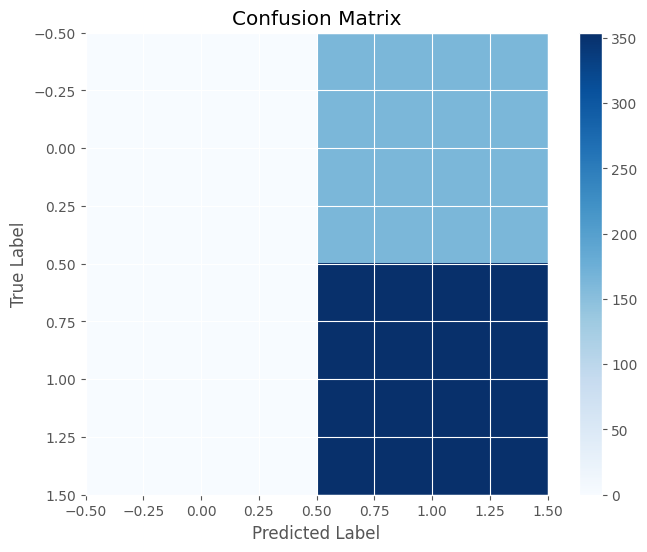

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:\n", conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# 3. Precision, Recall, and F1-score
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       162
           1       0.69      1.00      0.81       354

    accuracy                           0.69       516
   macro avg       0.34      0.50      0.41       516
weighted avg       0.47      0.69      0.56       516



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


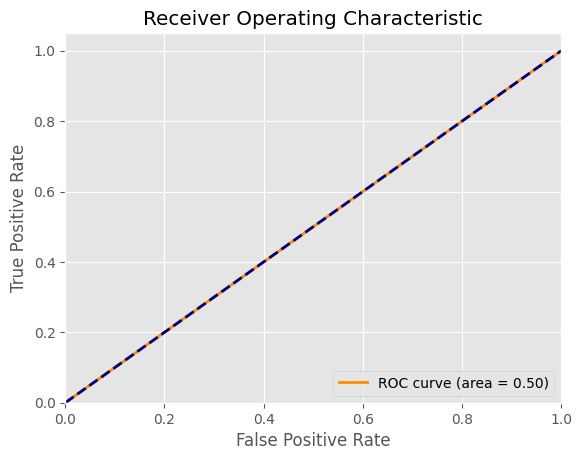

In [ ]:
# 4. ROC Curve and AUC (if binary classification)
if len(np.unique(y_test)) == 2:
    fpr, tpr, _ = roc_curve(y_test, y_pred_test)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# 5. Error Analysis
# individual instances where the model made incorrect predictions
incorrect_predictions = [(true_label, pred_label, text) for true_label, pred_label, text in zip(y_test, y_pred_test, X_test) if true_label != pred_label]
print("Incorrect Predictions:")
for true_label, pred_label, text in incorrect_predictions:
    print("True Label:", true_label)
    print("Predicted Label:", pred_label)
    print("Text:", text)
    print()

Incorrect Predictions:
True Label: 0
Predicted Label: 1
Text: [-2.14410499e-01  4.00887802e-02  3.62546206e-01  4.41042185e-01
  7.38193035e-01 -8.06540132e-01 -2.27923661e-01  6.50060058e-01
 -1.02552783e+00 -1.30997106e-01 -4.99155521e-01 -7.64933705e-01
 -1.24889035e-02  9.88066792e-01  7.36407936e-01 -4.75402653e-01
 -5.39949723e-02 -3.53361040e-01 -3.04171443e-01 -9.91651654e-01
 -1.10219538e-01  3.77372712e-01  2.94897705e-01 -2.55896270e-01
  8.50636512e-02  9.24334377e-02 -3.48125070e-01  4.69426773e-02
 -4.19443958e-02  1.09623671e-02 -1.62088081e-01 -7.29226395e-02
  6.11928105e-03 -5.99337704e-02  1.26363724e-01  5.94993591e-01
  3.30241501e-01 -1.23277709e-01 -4.62188560e-04 -3.64665836e-01
  1.66837610e-02 -3.77109706e-01 -5.87663770e-01  5.92852831e-01
  4.36553568e-01  1.08209059e-01 -6.86033905e-01  3.06424379e-01
  2.78788954e-01  2.31964394e-01 -2.57503334e-02 -2.90248722e-01
 -2.36068040e-01  3.61791849e-01 -2.63410747e-01  1.77950978e-01
  7.20590413e-01 -1.95812364

## ELMo

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd

# Load the pre-trained ELMo model from TensorFlow Hub
elmo = hub.KerasLayer("https://tfhub.dev/google/elmo/3")

# Function to convert a sentence to its ELMo embedding
def get_elmo_embedding(sentence):
    embeddings = elmo([sentence], signature="default", as_dict=True)["default"]
    return embeddings

In [ ]:
elmo = hub.load("https://tfhub.dev/google/elmo/3").signatures["default"]

x = ["Hello world!"]
embeddings = elmo(tf.constant(x))["elmo"]

print(embeddings.shape)
print(embeddings.numpy())

In [ ]:
x = ["Hello world!","hi"]
embeddings = elmo(tf.constant(x))["elmo"]

print(embeddings.shape)
print(embeddings.numpy())

In [ ]:
def get_elmo_embeds(sentences):
  embeds = elmo(tf.constant(sentences))["elmo"]
  return embeds

In [ ]:
X_train

In [ ]:
X_train_embeddings= get_elmo_embeds(X_train[:1000])

In [ ]:
X_train_embeddings.shape

In [ ]:
X_train_embeddings_reshaped = tf.reshape(X_train_embeddings, [-1, X_train_embeddings.shape[-1]])

In [ ]:
# Initialize SVM classifier
svm_classifier = SVC(kernel='linear')

# Train the SVM classifier
svm_classifier.fit(X_train_embeddings_reshaped, y_train)

GLoVE EMBEDDINGS

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [ ]:
# Load GloVe word vectors
glove_file = datapath('glove.6B.100d.txt')
tmp_file = get_tmpfile("test_word2vec.txt")
_ = glove2word2vec(glove_file, tmp_file)
model = KeyedVectors.load_word2vec_format(tmp_file)

### PHENOMENON SPECIFIC PERFORMANCE

Inchoative

In [ ]:
path_new = '/content/drive/My Drive/capstoneproject/acceptability_corpus/phenomena/'

In [ ]:
inchoative_df = pd.read_csv(path_new+'inchoative.tsv',sep="\t", header=None)
print(inchoative_df.shape)
print(inchoative_df.iloc[:,1].mean())
inchoative_df.sample(5)

(182, 4)
0.6978021978021978


,0,1,2,3
115,NaN,0,NaN,the book wrote .
104,NaN,1,NaN,rebecca devoured the cake .
174,NaN,1,NaN,rebecca deposited the cash .
116,NaN,1,NaN,elizabeth wrote the article .
29,NaN,1,NaN,the bowl cracked .


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(inchoative_df[3], inchoative_df[1], test_size=0.2, random_state=42)

In [ ]:
# Tokenize sentences
def tokenize_sentences(df):
    tokenized_sentences = []
    for sentence in df:
        tokens = word_tokenize(sentence.lower())
        tokenized_sentences.append(tokens)
    return tokenized_sentences

tokenized_train = tokenize_sentences(X_train)
# tokenized_val = tokenize_sentences(val_df)
tokenized_test = tokenize_sentences(X_test)

In [ ]:
X_test

19                 the glass shattered .
42           kelly dropped the platter .
154           michael peeled the onion .
98                  david ate the cake .
146           nicole chopped the apple .
15                   the platter broke .
24              david cracked the vase .
68              rebecca melted the ice .
115                     the book wrote .
96                 kelly ate the apple .
95                     the floor swept .
160         jessica polished the brass .
69                      the ice melted .
111                   the article read .
45                     the ball rolled .
16            kelly shattered the vase .
51                       the bag moved .
127                       the play saw .
97                       the apple ate .
56             rebecca popped the ball .
174         rebecca deposited the cash .
122             kelly watched the play .
144              nicole cut the garlic .
30       elizabeth cracked the platter .
9               

In [ ]:
tokenized_test

[['the', 'glass', 'shattered', '.'],
 ['kelly', 'dropped', 'the', 'platter', '.'],
 ['michael', 'peeled', 'the', 'onion', '.'],
 ['david', 'ate', 'the', 'cake', '.'],
 ['nicole', 'chopped', 'the', 'apple', '.'],
 ['the', 'platter', 'broke', '.'],
 ['david', 'cracked', 'the', 'vase', '.'],
 ['rebecca', 'melted', 'the', 'ice', '.'],
 ['the', 'book', 'wrote', '.'],
 ['kelly', 'ate', 'the', 'apple', '.'],
 ['the', 'floor', 'swept', '.'],
 ['jessica', 'polished', 'the', 'brass', '.'],
 ['the', 'ice', 'melted', '.'],
 ['the', 'article', 'read', '.'],
 ['the', 'ball', 'rolled', '.'],
 ['kelly', 'shattered', 'the', 'vase', '.'],
 ['the', 'bag', 'moved', '.'],
 ['the', 'play', 'saw', '.'],
 ['the', 'apple', 'ate', '.'],
 ['rebecca', 'popped', 'the', 'ball', '.'],
 ['rebecca', 'deposited', 'the', 'cash', '.'],
 ['kelly', 'watched', 'the', 'play', '.'],
 ['nicole', 'cut', 'the', 'garlic', '.'],
 ['elizabeth', 'cracked', 'the', 'platter', '.'],
 ['the', 'vase', 'broke', '.'],
 ['the', 'play', 'wat

In [ ]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1, workers=4)

# Convert sentences to average word embeddings
def sentence_to_avg_embedding(sentence, model):
    word_embeddings = [model.wv[word] for word in sentence if word in model.wv]
    if word_embeddings:
        return np.mean(word_embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

In [ ]:
X_train_arr = np.array([sentence_to_avg_embedding(sentence, word2vec_model) for sentence in tokenized_train])
X_test_arr = np.array([sentence_to_avg_embedding(sentence, word2vec_model) for sentence in tokenized_test])

In [ ]:
# Train SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_arr, y_train)

SVC(kernel='linear')

In [ ]:
# Test SVM classifier
y_pred_train = svm_classifier.predict(X_train_arr)
y_pred_test = svm_classifier.predict(X_test_arr)

In [ ]:
# Evaluate SVM classifier
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

In [ ]:
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.6827586206896552
Test Accuracy: 0.7567567567567568


In [ ]:
# 5. Error Analysis
# individual instances where the model made incorrect predictions
incorrect_predictions = [(true_label, pred_label, text) for true_label, pred_label, text in zip(y_test, y_pred_test, X_test) if true_label != pred_label]
print("Incorrect Predictions:")
for true_label, pred_label, text in incorrect_predictions:
    print("True Label:", true_label)
    print("Predicted Label:", pred_label)
    print("Text:", text)
    print()

Incorrect Predictions:
True Label: 0
Predicted Label: 1
Text: the book wrote .

True Label: 0
Predicted Label: 1
Text: the floor swept .

True Label: 0
Predicted Label: 1
Text: the article read .

True Label: 0
Predicted Label: 1
Text: the play saw .

True Label: 0
Predicted Label: 1
Text: the apple ate .

True Label: 0
Predicted Label: 1
Text: the play watched .

True Label: 0
Predicted Label: 1
Text: the dilemma understood .

True Label: 0
Predicted Label: 1
Text: the onion cut .

True Label: 0
Predicted Label: 1
Text: the novel wrote .



Reflexive

In [ ]:
reflexive_df = pd.read_csv(path_new+'reflexive.tsv',sep="\t", header=None)
print(reflexive_df.shape)
print(reflexive_df.iloc[:,1].mean())
reflexive_df.sample(5)

(144, 4)
0.16666666666666666


,0,1,2,3
60,NaN,0,NaN,he saw yourself .
53,NaN,0,NaN,he talked to herself .
110,NaN,0,NaN,we surprised yourself .
119,NaN,1,NaN,we amused ourselves .
32,NaN,0,NaN,you saw themselves .


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(reflexive_df[3], reflexive_df[1], test_size=0.2, random_state=42)

In [ ]:
tokenized_train = tokenize_sentences(X_train)
# tokenized_val = tokenize_sentences(val_df)
tokenized_test = tokenize_sentences(X_test)

In [ ]:
X_train_arr = np.array([sentence_to_avg_embedding(sentence, word2vec_model) for sentence in tokenized_train])
X_test_arr = np.array([sentence_to_avg_embedding(sentence, word2vec_model) for sentence in tokenized_test])

In [ ]:
# Train SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_arr, y_train)

SVC(kernel='linear')

In [ ]:
# Test SVM classifier
y_pred_train = svm_classifier.predict(X_train_arr)
y_pred_test = svm_classifier.predict(X_test_arr)

In [ ]:
# Evaluate SVM classifier
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.8434782608695652
Test Accuracy: 0.7931034482758621


In [ ]:
# 5. Error Analysis
# individual instances where the model made incorrect predictions
incorrect_predictions = [(true_label, pred_label, text) for true_label, pred_label, text in zip(y_test, y_pred_test, X_test) if true_label != pred_label]
print("Incorrect Predictions:")
for true_label, pred_label, text in incorrect_predictions:
    print("True Label:", true_label)
    print("Predicted Label:", pred_label)
    print("Text:", text)
    print()

Incorrect Predictions:
True Label: 1
Predicted Label: 0
Text: we talked to ourselves .

True Label: 1
Predicted Label: 0
Text: i amused myself .

True Label: 1
Predicted Label: 0
Text: i surprised myself .

True Label: 1
Predicted Label: 0
Text: he amused himself .

True Label: 1
Predicted Label: 0
Text: she surprised herself .

True Label: 1
Predicted Label: 0
Text: we amused ourselves .



In [ ]:
# 5. Error Analysis
# individual instances where the model made incorrect predictions
incorrect_predictions = [(true_label, pred_label, text) for true_label, pred_label, text in zip(y_test, y_pred_test, X_test) if true_label == pred_label]
print("Incorrect Predictions:")
for true_label, pred_label, text in incorrect_predictions:
    print("True Label:", true_label)
    print("Predicted Label:", pred_label)
    print("Text:", text)
    print()

Incorrect Predictions:
True Label: 0
Predicted Label: 0
Text: she surprised themselves .

True Label: 0
Predicted Label: 0
Text: we talked to himself .

True Label: 0
Predicted Label: 0
Text: he saw themselves .

True Label: 0
Predicted Label: 0
Text: i saw yourself .

True Label: 0
Predicted Label: 0
Text: they saw yourself .

True Label: 0
Predicted Label: 0
Text: he talked to myself .

True Label: 0
Predicted Label: 0
Text: he surprised myself .

True Label: 0
Predicted Label: 0
Text: she surprised ourselves .

True Label: 0
Predicted Label: 0
Text: they talked to yourself .

True Label: 0
Predicted Label: 0
Text: we saw herself .

True Label: 0
Predicted Label: 0
Text: he saw myself .

True Label: 0
Predicted Label: 0
Text: you amused himself .

True Label: 0
Predicted Label: 0
Text: he talked to ourselves .

True Label: 0
Predicted Label: 0
Text: they talked to herself .

True Label: 0
Predicted Label: 0
Text: she talked to himself .

True Label: 0
Predicted Label: 0
Text: i amuse

Singular Pl

In [ ]:
singular_pl_df = pd.read_csv(path_new+'singular_pl.tsv',sep="\t", header=None)
print(singular_pl_df.shape)
print(singular_pl_df.iloc[:,1].mean())
singular_pl_df.sample(5)

(676, 4)
0.5


,0,1,2,3
621,NaN,1,NaN,john and his wife have the flu .
263,NaN,1,NaN,john knows where to go .
565,NaN,1,NaN,the doctors sleep here .
132,NaN,1,NaN,the dancer likes to read .
346,NaN,0,NaN,the boys has to go .


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(singular_pl_df[3], singular_pl_df[1], test_size=0.2, random_state=42)

In [ ]:
tokenized_train = tokenize_sentences(X_train)
# tokenized_val = tokenize_sentences(val_df)
tokenized_test = tokenize_sentences(X_test)

In [ ]:
X_train_arr = np.array([sentence_to_avg_embedding(sentence, word2vec_model) for sentence in tokenized_train])
X_test_arr = np.array([sentence_to_avg_embedding(sentence, word2vec_model) for sentence in tokenized_test])

In [ ]:
# Train SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_arr, y_train)

SVC(kernel='linear')

In [ ]:
# Test SVM classifier
y_pred_train = svm_classifier.predict(X_train_arr)
y_pred_test = svm_classifier.predict(X_test_arr)

In [ ]:
# Evaluate SVM classifier
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.5055555555555555
Test Accuracy: 0.47794117647058826


In [ ]:
# 5. Error Analysis
# individual instances where the model made incorrect predictions
incorrect_predictions = [(true_label, pred_label, text) for true_label, pred_label, text in zip(y_test, y_pred_test, X_test) if true_label != pred_label]
print("Incorrect Predictions:")
for true_label, pred_label, text in incorrect_predictions:
    print("True Label:", true_label)
    print("Predicted Label:", pred_label)
    print("Text:", text)
    print()

Incorrect Predictions:
True Label: 1
Predicted Label: 0
Text: mr. and mrs. smith seem nice .

True Label: 1
Predicted Label: 0
Text: the dancers are n't going to come .

True Label: 1
Predicted Label: 0
Text: he likes to read .

True Label: 1
Predicted Label: 0
Text: mr. and mrs. smith have to go .

True Label: 1
Predicted Label: 0
Text: the guests of honor are here .

True Label: 1
Predicted Label: 0
Text: he knows where to go .

True Label: 1
Predicted Label: 0
Text: mr. and mrs. smith like to read .

True Label: 1
Predicted Label: 0
Text: the dancers are here .

True Label: 1
Predicted Label: 0
Text: some woman has n't been there .

True Label: 1
Predicted Label: 0
Text: my friend is n't going to come .

True Label: 1
Predicted Label: 0
Text: those guys like to read .

True Label: 1
Predicted Label: 0
Text: mary has the flu .

True Label: 1
Predicted Label: 0
Text: the doctor is n't going to come .

True Label: 1
Predicted Label: 0
Text: everyone has to go .

True Label: 1
Predicted

In [ ]:
# 5. Error Analysis
# individual instances where the model made incorrect predictions
incorrect_predictions = [(true_label, pred_label, text) for true_label, pred_label, text in zip(y_test, y_pred_test, X_test) if true_label == pred_label]
print("Incorrect Predictions:")
for true_label, pred_label, text in incorrect_predictions:
    print("True Label:", true_label)
    print("Predicted Label:", pred_label)
    print("Text:", text)
    print()

Incorrect Predictions:
True Label: 0
Predicted Label: 0
Text: mr. smith know where to go .

True Label: 0
Predicted Label: 0
Text: they is walking .

True Label: 0
Predicted Label: 0
Text: some women has a problem .

True Label: 0
Predicted Label: 0
Text: some woman have the flu .

True Label: 0
Predicted Label: 0
Text: the dancers has the flu .

True Label: 0
Predicted Label: 0
Text: he are n't going to come .

True Label: 0
Predicted Label: 0
Text: john seem nice .

True Label: 0
Predicted Label: 0
Text: mr. smith are walking .

True Label: 0
Predicted Label: 0
Text: mr. and mrs. smith sleeps here .

True Label: 0
Predicted Label: 0
Text: we is here .

True Label: 0
Predicted Label: 0
Text: the dancer like to read .

True Label: 0
Predicted Label: 0
Text: that guy have n't been there .

True Label: 0
Predicted Label: 0
Text: john have n't been there .

True Label: 0
Predicted Label: 0
Text: mr. and mrs. smith seems nice .

True Label: 0
Predicted Label: 0
Text: the guest of honor sle

SVO

In [ ]:
svo_df = pd.read_csv(path_new+'svo.tsv',sep="\t", header=None)
print(svo_df.shape)
print(svo_df.iloc[:,1].mean())
svo_df.sample(5)

(500, 4)
0.2


,0,1,2,3
216,NaN,0,NaN,james the article wrote .
317,NaN,0,NaN,wrote jessica the article .
294,NaN,0,NaN,the chapter read nicole .
230,NaN,1,NaN,james read the story .
289,NaN,0,NaN,the story wrote nicole .


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(svo_df[3], svo_df[1], test_size=0.2, random_state=42)

In [ ]:
tokenized_train = tokenize_sentences(X_train)
# tokenized_val = tokenize_sentences(val_df)
tokenized_test = tokenize_sentences(X_test)

In [ ]:
X_train_arr = np.array([sentence_to_avg_embedding(sentence, word2vec_model) for sentence in tokenized_train])
X_test_arr = np.array([sentence_to_avg_embedding(sentence, word2vec_model) for sentence in tokenized_test])

In [ ]:
# Train SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_arr, y_train)

SVC(kernel='linear')

In [ ]:
# Test SVM classifier
y_pred_train = svm_classifier.predict(X_train_arr)
y_pred_test = svm_classifier.predict(X_test_arr)

In [ ]:
# Evaluate SVM classifier
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.805
Test Accuracy: 0.78


In [ ]:
# 5. Error Analysis
# individual instances where the model made incorrect predictions
incorrect_predictions = [(true_label, pred_label, text) for true_label, pred_label, text in zip(y_test, y_pred_test, X_test) if true_label != pred_label]
print("Incorrect Predictions:")
for true_label, pred_label, text in incorrect_predictions:
    print("True Label:", true_label)
    print("Predicted Label:", pred_label)
    print("Text:", text)
    print()

Incorrect Predictions:
True Label: 1
Predicted Label: 0
Text: david wrote the book .

True Label: 1
Predicted Label: 0
Text: kelly read the book .

True Label: 1
Predicted Label: 0
Text: kelly wrote the chapter .

True Label: 1
Predicted Label: 0
Text: michael read the story .

True Label: 1
Predicted Label: 0
Text: kelly read the chapter .

True Label: 1
Predicted Label: 0
Text: nicole read the story .

True Label: 1
Predicted Label: 0
Text: kelly wrote the letter .

True Label: 1
Predicted Label: 0
Text: rebecca read the chapter .

True Label: 1
Predicted Label: 0
Text: christopher read the letter .

True Label: 1
Predicted Label: 0
Text: kelly wrote the story .

True Label: 1
Predicted Label: 0
Text: david wrote the story .

True Label: 1
Predicted Label: 0
Text: michael read the book .

True Label: 1
Predicted Label: 0
Text: rebecca wrote the article .

True Label: 1
Predicted Label: 0
Text: rebecca read the article .

True Label: 1
Predicted Label: 0
Text: christopher wrote the bo

In [ ]:
# 5. Error Analysis
# individual instances where the model made incorrect predictions
incorrect_predictions = [(true_label, pred_label, text) for true_label, pred_label, text in zip(y_test, y_pred_test, X_test) if true_label == pred_label]
print("Incorrect Predictions:")
for true_label, pred_label, text in incorrect_predictions:
    print("True Label:", true_label)
    print("Predicted Label:", pred_label)
    print("Text:", text)
    print()

Incorrect Predictions:
True Label: 0
Predicted Label: 0
Text: elizabeth the article read .

True Label: 0
Predicted Label: 0
Text: read the letter christopher .

True Label: 0
Predicted Label: 0
Text: the letter read elizabeth .

True Label: 0
Predicted Label: 0
Text: the book read jason .

True Label: 0
Predicted Label: 0
Text: the chapter read elizabeth .

True Label: 0
Predicted Label: 0
Text: wrote elizabeth the letter .

True Label: 0
Predicted Label: 0
Text: the letter read jason .

True Label: 0
Predicted Label: 0
Text: wrote the article christopher .

True Label: 0
Predicted Label: 0
Text: the book wrote michael .

True Label: 0
Predicted Label: 0
Text: the chapter read david .

True Label: 0
Predicted Label: 0
Text: rebecca the book wrote .

True Label: 0
Predicted Label: 0
Text: the story read christopher .

True Label: 0
Predicted Label: 0
Text: elizabeth the letter read .

True Label: 0
Predicted Label: 0
Text: wrote the story elizabeth .

True Label: 0
Predicted Label: 0
T

Wh Extraction

In [ ]:
wh_extraction_df = pd.read_csv(path_new+'wh_extraction.tsv',sep="\t", header=None)
print(wh_extraction_df.shape)
print(wh_extraction_df.iloc[:,1].mean())
wh_extraction_df.sample(5)

(520, 4)
0.5


,0,1,2,3
126,NaN,0,NaN,what did christopher eat the salad ?
449,NaN,1,NaN,what did jason sweep ?
66,NaN,0,NaN,what did jessica read the story ?
173,NaN,1,NaN,what did james eat ?
349,NaN,1,NaN,what did james rake ?


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(wh_extraction_df[3], wh_extraction_df[1], test_size=0.2, random_state=42)

In [ ]:
tokenized_train = tokenize_sentences(X_train)
# tokenized_val = tokenize_sentences(val_df)
tokenized_test = tokenize_sentences(X_test)

In [ ]:
X_train_arr = np.array([sentence_to_avg_embedding(sentence, word2vec_model) for sentence in tokenized_train])
X_test_arr = np.array([sentence_to_avg_embedding(sentence, word2vec_model) for sentence in tokenized_test])

In [ ]:
# Train SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_arr, y_train)

SVC(kernel='linear')

In [ ]:
# Test SVM classifier
y_pred_train = svm_classifier.predict(X_train_arr)
y_pred_test = svm_classifier.predict(X_test_arr)

In [ ]:
# Evaluate SVM classifier
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.9879807692307693
Test Accuracy: 0.9711538461538461


In [ ]:
# 5. Error Analysis
# individual instances where the model made incorrect predictions
incorrect_predictions = [(true_label, pred_label, text) for true_label, pred_label, text in zip(y_test, y_pred_test, X_test) if true_label != pred_label]
print("Incorrect Predictions:")
for true_label, pred_label, text in incorrect_predictions:
    print("True Label:", true_label)
    print("Predicted Label:", pred_label)
    print("Text:", text)
    print()

Incorrect Predictions:
True Label: 0
Predicted Label: 1
Text: what did kelly read the book ?

True Label: 0
Predicted Label: 1
Text: what did david read the book ?

True Label: 0
Predicted Label: 1
Text: what did jason read the article ?



In [ ]:
# 5. Error Analysis
# individual instances where the model made incorrect predictions
incorrect_predictions = [(true_label, pred_label, text) for true_label, pred_label, text in zip(y_test, y_pred_test, X_test) if true_label == pred_label]
print("Incorrect Predictions:")
for true_label, pred_label, text in incorrect_predictions:
    print("True Label:", true_label)
    print("Predicted Label:", pred_label)
    print("Text:", text)
    print()

Incorrect Predictions:
True Label: 1
Predicted Label: 1
Text: what did david bake ?

True Label: 1
Predicted Label: 1
Text: what did kelly read ?

True Label: 0
Predicted Label: 0
Text: what did michael read the story ?

True Label: 1
Predicted Label: 1
Text: what did james devour ?

True Label: 1
Predicted Label: 1
Text: what did rebecca ride ?

True Label: 0
Predicted Label: 0
Text: what did michael boil the potato ?

True Label: 0
Predicted Label: 0
Text: what did rebecca devour the cake ?

True Label: 0
Predicted Label: 0
Text: what did nicole eat the sandwich ?

True Label: 0
Predicted Label: 0
Text: what did michael ride the train ?

True Label: 0
Predicted Label: 0
Text: what did elizabeth devour the steak ?

True Label: 0
Predicted Label: 0
Text: what did nicole devour the cake ?

True Label: 1
Predicted Label: 1
Text: what did christopher erase ?

True Label: 0
Predicted Label: 0
Text: what did elizabeth ride the bicycle ?

True Label: 0
Predicted Label: 0
Text: what did chris